In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from os import getcwd, path as path_lib
import math

HOME_PATH = "/home/finkensim"
SCENE_NAME = "All_2Cop.csv"

log_path = path_lib.join(HOME_PATH, "paparazzi", "logs")
conSteer_path = path_lib.join(log_path, "ConSteer")
attRep_path = path_lib.join(log_path, "AttRep")
scene_path = path_lib.join(path_lib.dirname(getcwd()),"Project-Code","Scenarios",SCENE_NAME)

# for scene_path use scene.csv not scene_swarm_position.csv file path
# for log_path link to drone log file directory that matches with the scene,
# which has the sub directories AttRep and ConSteer

In [2]:
drone_ids = {"attRep":[*range(30,40)],"conSteer":[*range(50,60)]}
attRep_files = glob(path_lib.join(attRep_path,"*.log"))
conSteer_files = glob(path_lib.join(conSteer_path,"*.log"))

if(len(attRep_files) == len(drone_ids["attRep"]) and  
   len(conSteer_files) == len(drone_ids["conSteer"])):
   print("Retrieved all log-Files successfully!")

Retrieved all log-Files successfully!


In [3]:
# gets the metric distance between two points given in the LlaCoor_f format
def getDistance(own_pos_lat, own_pos_lon, goal_pos_lat, goal_pos_lon)->float:
    # GLOBE_RADIUS:int = int(6371000)
    own_pos_lat *= math.pi/180
    own_pos_lon *= math.pi/180
    goal_pos_lat *= math.pi/180
    goal_pos_lon *= math.pi/180
    return float( 6371000 * math.acos(                  
        math.sin(own_pos_lat) * math.sin(goal_pos_lat) +    
        math.cos(own_pos_lat) * math.cos(goal_pos_lat) *    
        math.cos(own_pos_lon - goal_pos_lon)
    ))

# Evaluation of Context Steering Behaviour

In [4]:
drone_protocol = dict()
timestamps = list()

for d_id,file_path in zip(drone_ids["conSteer"],conSteer_files):
    drone_protocol[d_id] = dict()
    with open(file_path,"r") as file:
        d_timestamps = list()
        lines = file.readlines()
        for line in lines[1:-1]:
            key = float(line.split("]")[0].strip("[").strip())
            pos = [float(coord.strip()) for coord in line.split("pos:")[-1].split("/")[0].split(",")]
            drone_protocol[d_id][key] = pos
            d_timestamps.append(key)
        if d_id == drone_ids["conSteer"][0]: timestamps = d_timestamps
        else: timestamps = [timestamp for timestamp in timestamps if timestamp in d_timestamps]

print(drone_protocol.keys())
for key in drone_protocol.keys():
    print("-> protocol from drone "+str(key)+": ")
    print("   first_timestamp:",list(drone_protocol[key].keys())[0])
    print("   first_pos:",drone_protocol[key][list(drone_protocol[key].keys())[0]])
    print("   timestamp_amount:",len(drone_protocol[key].keys()))


dict_keys([50, 51, 52, 53, 54, 55, 56, 57, 58, 59])
-> protocol from drone 50: 
   first_timestamp: 0.02931
   first_pos: [52.13786995, 11.64462132]
   timestamp_amount: 222
-> protocol from drone 51: 
   first_timestamp: 0.02931
   first_pos: [52.13783922, 11.64487916]
   timestamp_amount: 222
-> protocol from drone 52: 
   first_timestamp: 0.02931
   first_pos: [52.13788361, 11.64478525]
   timestamp_amount: 222
-> protocol from drone 53: 
   first_timestamp: 0.02931
   first_pos: [52.13790069, 11.64436604]
   timestamp_amount: 222
-> protocol from drone 54: 
   first_timestamp: 0.02931
   first_pos: [52.13742258, 11.64456497]
   timestamp_amount: 222
-> protocol from drone 55: 
   first_timestamp: 0.02931
   first_pos: [52.13811584, 11.64491502]
   timestamp_amount: 222
-> protocol from drone 56: 
   first_timestamp: 0.02931
   first_pos: [52.13800656, 11.64478354]
   timestamp_amount: 222
-> protocol from drone 57: 
   first_timestamp: 0.02931
   first_pos: [52.13846418, 11.6448509

In [5]:
scene = dict()

with open(scene_path, "r") as file:
    lines = file.readlines()
    for line in lines[2:]:
        vals = [val.strip() for val in line.split(",")]
        scene[vals[-1]] = scene.get(vals[-1], [])
        scene[vals[-1]].append([round(float(vals[0]),8),round(float(vals[1]),8)])

print(scene.keys())
for key in scene.keys():
    print("-> "+str(key)+"s in scene: ")
    print("   first_"+str(key)+":",scene[key][0])
    print("   "+str(key)+"_amount:",len(scene[key]))

dict_keys(['rep', 'att', 'spawn'])
-> reps in scene: 
   first_rep: [52.13806987, 11.64556749]
   rep_amount: 30
-> atts in scene: 
   first_att: [52.13878079, 11.6445159]
   att_amount: 30
-> spawns in scene: 
   first_spawn: [52.13788439, 11.64478467]
   spawn_amount: 10


Goal Achievement Analysis

In [6]:
reached = {}
last_goal_time = 0
last_drone_pos = [drone_protocol[d_id][timestamps[0]] for d_id in drone_protocol.keys()]
for timestamp in timestamps:
    for d_id in drone_protocol.keys():
        for att_id, att in enumerate(scene["att"]):
            if getDistance(*drone_protocol[d_id][timestamp],*att) < 1.5 \
            and not reached.get(str(d_id)+"->"+str(att_id), None):
                reached[str(d_id)+"->"+str(att_id)] = [getDistance(*last_drone_pos[drone_ids["conSteer"].index(d_id)],*att),timestamp-last_goal_time]
                last_drone_pos = [drone_protocol[d_id][timestamp] for d_id in drone_protocol.keys()]
                last_goal_time = timestamp

for key in reached.keys():
    print("Drone",key.split("->")[0],"reached Goal Point",key.split("->")[1],"approximately after",
    str(reached[key][1])+"sec and {:.8f}m of travel.".format(reached[key][0]))

Drone 57 reached Goal Point 0 approximately after 42.282604sec and 41.98094265m of travel.
Drone 51 reached Goal Point 1 approximately after 2.3916970000000006sec and 8.48755544m of travel.
Drone 56 reached Goal Point 1 approximately after 6.776474sec and 20.79191396m of travel.
Drone 54 reached Goal Point 1 approximately after 1.993079999999999sec and 5.15455832m of travel.
Drone 50 reached Goal Point 1 approximately after 3.1889269999999996sec and 2.55091693m of travel.
Drone 52 reached Goal Point 1 approximately after 3.1889269999999996sec and 5.12386832m of travel.
Drone 59 reached Goal Point 0 approximately after 0.0sec and 0.93017215m of travel.
Drone 55 reached Goal Point 0 approximately after 3.986159999999998sec and 11.83573251m of travel.
Drone 53 reached Goal Point 1 approximately after 16.741875000000007sec and 5.97564726m of travel.
Drone 58 reached Goal Point 0 approximately after 6.377853000000002sec and 6.20647452m of travel.


Danger Avoidance Analysis

In [7]:
min_dist = {}
for timestamp in timestamps:
    for d_id in drone_protocol.keys():
        for rep_id, rep in enumerate(scene["rep"]):
            dist = getDistance(*drone_protocol[d_id][timestamp],*rep)
            if not min_dist.get(str(d_id)+"<->"+str(rep_id), None) \
            or dist < min_dist[str(d_id)+"<->"+str(rep_id)][1]:
                min_dist[str(d_id)+"<->"+str(rep_id)] = [timestamp, dist]

for key in min_dist.keys():
    print("Smallest distance between Drone",key.split("<->")[0],"and Danger Point",key.split("<->")[1],
    "was {0:.8f}m and occured".format(round(min_dist[key][1],8)),
    "{0:.6f}sec after simulation start.".format(min_dist[key][0]))

Smallest distance between Drone 50 and Danger Point 0 was 54.11503517m and occured 70.982956sec after simulation start.
Smallest distance between Drone 50 and Danger Point 1 was 268.90613775m and occured 66.996796sec after simulation start.
Smallest distance between Drone 50 and Danger Point 2 was 77.06892863m and occured 28.331045sec after simulation start.
Smallest distance between Drone 50 and Danger Point 3 was 167.53000462m and occured 64.206490sec after simulation start.
Smallest distance between Drone 50 and Danger Point 4 was 207.71101229m and occured 0.029310sec after simulation start.
Smallest distance between Drone 50 and Danger Point 5 was 155.60106753m and occured 0.029310sec after simulation start.
Smallest distance between Drone 50 and Danger Point 6 was 94.81721996m and occured 65.003716sec after simulation start.
Smallest distance between Drone 50 and Danger Point 7 was 51.85779280m and occured 28.331045sec after simulation start.
Smallest distance between Drone 50 and

Swarming Analysis

In [8]:
entropy = list()
for timestamp in timestamps:
    drone_pos = np.array([drone_protocol[d_id][timestamp] for d_id in drone_protocol.keys()])
    centeroid = np.average(drone_pos,axis=0)
    dist = np.linalg.norm(drone_pos - centeroid, axis=1)
    probs = dist/np.sum(dist)
    entropy.append(-np.sum(probs*np.log2(probs)))
print("Average Entropy: {:.4f} - std: {:.4f}".format(np.average(entropy),np.std(entropy)))


Average Entropy: 3.1704 - std: 0.1205


In [9]:
dr_min_dist = list()
drone_pairs = list()
for timestamp in timestamps:
    drone_pos = np.array([drone_protocol[d_id][timestamp] for d_id in drone_protocol.keys()])
    min_drone_dist = dict()
    for i,d_pos in enumerate(drone_pos):
        dists = dict()
        for j,o_pos in enumerate(drone_pos[i+1:]):
            if d_pos[0]-o_pos[0] == 0 and d_pos[1]-o_pos[1] == 0: dists[0] = str(i)+"<->"+str(j+i+1)
            else: dists[abs(getDistance(*d_pos,*o_pos))] = str(i)+"<->"+str(j+i+1)
        if dists: min_drone_dist[np.min(list(dists.keys()))] = dists[np.min(list(dists.keys()))]
    dr_min_dist.append(np.min(list(min_drone_dist.keys())))
    drone_pairs.append(min_drone_dist[dr_min_dist[-1]])

for key,dist,time in zip(drone_pairs[::75],dr_min_dist[::75],timestamps[::75]):
    print("Smallest distance between Drone",str(drone_ids["conSteer"][int(key.split("<->")[0])]),"and Drone",
    str(drone_ids["conSteer"][int(key.split("<->")[1])]),"was {0:.8f}m and occured".format(round(dist,8)),
    "{0:.6f}sec after simulation start.".format(time))

Smallest distance between Drone 50 and Drone 58 was 3.04385721m and occured 0.029310sec after simulation start.
Smallest distance between Drone 50 and Drone 58 was 4.18254368m and occured 29.925510sec after simulation start.
Smallest distance between Drone 57 and Drone 59 was 1.62780127m and occured 59.821709sec after simulation start.


Behaviour Evaluation

In [10]:
# Goal Stats
fastest_goal,slowest_goal,avg_goal,std_goal,percentiles_goal = (-1,-1,-1,-1,[-1,-1,-1])
if reached:
    fastest_goal = min([tuplett[1]/tuplett[0] for tuplett in reached.values()])
    slowest_goal = max([tuplett[1]/tuplett[0] for tuplett in reached.values()])
    avg_goal = np.average([tuplett[1]/tuplett[0] for tuplett in reached.values()])
    std_goal = np.std([tuplett[1]/tuplett[0] for tuplett in reached.values()])
    percentiles_goal = np.percentile([tuplett[1]/tuplett[0] for tuplett in reached.values()],[25,50,75])

    print("Goal Stats:\n-----------")
    print("Shortest travel time to goal:           {:>5.2f} sec/m".format(round(fastest_goal,2)))
    print("Average travel time to goal:            {:>5.2f} sec/m".format(round(avg_goal,2)))
    print("Longest travel time to goal:            {:>5.2f} sec/m".format(round(slowest_goal,2)))
    print("Standard Deviation in travel times:     {:>5.2f} sec/m".format(round(std_goal,2)))
    print("First percentile(Q1) in travel times:   {:>5.2f} sec/m".format(round(percentiles_goal[0],2)))
    print("Median(2nd percentile) in travel times: {:>5.2f} sec/m".format(round(percentiles_goal[1],2)))
    print("Third percentile(Q3) in travel times:   {:>5.2f} sec/m".format(round(percentiles_goal[2],2)))
else:
    print("No Goal Points Reached!")

Goal Stats:
-----------
Shortest travel time to goal:            0.00 sec/m
Average travel time to goal:             0.80 sec/m
Longest travel time to goal:             2.80 sec/m
Standard Deviation in travel times:      0.77 sec/m
First percentile(Q1) in travel times:    0.33 sec/m
Median(2nd percentile) in travel times:  0.50 sec/m
Third percentile(Q3) in travel times:    1.02 sec/m


In [11]:
# Danger Stats
smallest_dist = min([tuplett[1] for tuplett in min_dist.values()])
furthest_dist = max([tuplett[1] for tuplett in min_dist.values()])
avg_dist = np.average([tuplett[1] for tuplett in min_dist.values()])
std_dist = np.std([tuplett[1] for tuplett in min_dist.values()])
percentiles_dist = np.percentile([tuplett[1] for tuplett in min_dist.values()],[25,50,75])

print("\nDanger Stats:\n-------------")
print("Smallest minimal distance to danger:         {:>6.2f} m".format(round(smallest_dist,2)))
print("Average minimal distance to danger:          {:>6.2f} m".format(round(avg_dist,2)))
print("Furthest minimal distance to danger:         {:>6.2f} m".format(round(furthest_dist,2)))
print("Standard Deviation in minimal distances:     {:>6.2f} m".format(round(std_dist,2)))
print("First percentile(Q1) in minimal distances:   {:>6.2f} m".format(round(percentiles_dist[0],2)))
print("Median(2nd percentile) in minimal distances: {:>6.2f} m".format(round(percentiles_dist[1],2)))
print("Third percentile(Q3) in minimal distances:   {:>6.2f} m".format(round(percentiles_dist[2],2)))


Danger Stats:
-------------
Smallest minimal distance to danger:           0.19 m
Average minimal distance to danger:          116.33 m
Furthest minimal distance to danger:         278.51 m
Standard Deviation in minimal distances:      68.17 m
First percentile(Q1) in minimal distances:    54.21 m
Median(2nd percentile) in minimal distances: 117.89 m
Third percentile(Q3) in minimal distances:   165.40 m


In [12]:
# Swarm Stats
smallest_entropy = min(entropy)
largest_entropy = max(entropy)
avg_entropy = np.average(entropy)
std_entropy = np.std(entropy)
percentiles_entropy = np.percentile(entropy,[25,50,75])

smallest_ddist = min(dr_min_dist)
furthest_ddist = max(dr_min_dist)
avg_ddist = np.average(dr_min_dist)
std_ddist = np.std(dr_min_dist)
percentiles_ddist = np.percentile(dr_min_dist,[25,50,75])

print("\nSwarm Stats:\n-------------")
print("Smallest entropy of swarm formation:         {:>6.4f}".format(round(smallest_entropy,4)))
print("Average entropy of swarm formation:          {:>6.4f}".format(round(avg_entropy,4)))
print("Largest entropy of swarm formation:          {:>6.4f}".format(round(largest_entropy,4)))
print("Standard Deviation in formation entropy:     {:>6.4f}".format(round(std_entropy,4)))
print("First percentile(Q1) in formation entropy:   {:>6.4f}".format(round(percentiles_entropy[0],4)))
print("Median(2nd percentile) in formation entropy: {:>6.4f}".format(round(percentiles_entropy[1],4)))
print("Third percentile(Q3) in formation entropy:   {:>6.4f}".format(round(percentiles_entropy[2],4)))
print("-----------------------------------------------------")
print("Smallest minimal distance to other drones:   {:>6.2f} m".format(round(smallest_ddist,2)))
print("Average minimal distance to other drones:    {:>6.2f} m".format(round(avg_ddist,2)))
print("Furthest minimal distance to other drones:   {:>6.2f} m".format(round(furthest_ddist,2)))
print("Standard Deviation in minimal distances:     {:>6.2f} m".format(round(std_ddist,2)))
print("First percentile(Q1) in minimal distances:   {:>6.2f} m".format(round(percentiles_ddist[0],2)))
print("Median(2nd percentile) in minimal distances: {:>6.2f} m".format(round(percentiles_ddist[1],2)))
print("Third percentile(Q3) in minimal distances:   {:>6.2f} m".format(round(percentiles_ddist[2],2)))


Swarm Stats:
-------------
Smallest entropy of swarm formation:         3.0162
Average entropy of swarm formation:          3.1704
Largest entropy of swarm formation:          3.2924
Standard Deviation in formation entropy:     0.1205
First percentile(Q1) in formation entropy:   3.0211
Median(2nd percentile) in formation entropy: 3.2248
Third percentile(Q3) in formation entropy:   3.2888
-----------------------------------------------------
Smallest minimal distance to other drones:     0.00 m
Average minimal distance to other drones:      2.37 m
Furthest minimal distance to other drones:     7.60 m
Standard Deviation in minimal distances:       1.51 m
First percentile(Q1) in minimal distances:     1.15 m
Median(2nd percentile) in minimal distances:   1.98 m
Third percentile(Q3) in minimal distances:     3.42 m


In [13]:
# Save Stats to file
result_file_path = path_lib.join(log_path, "conSteer_"+SCENE_NAME.strip(".csv")+"_res.csv")
with open(result_file_path, "w") as results:
    results.write("{:.12f},{:.12f},{:.12f},{:.12f},{:.12f},{:.12f}\n".format(
        round(slowest_goal,12),round(avg_goal,12),round(fastest_goal,12),
        round(std_goal,12),round(percentiles_goal[0],12),
        round(percentiles_goal[1],12),round(percentiles_goal[2],12)))
    results.write("{:.12f},{:.12f},{:.12f},{:.12f},{:.12f},{:.12f}\n".format(
        round(smallest_dist,12),round(avg_dist,12),round(furthest_dist,12),
        round(std_dist,12),round(percentiles_dist[0],12),
        round(percentiles_dist[1],12),round(percentiles_dist[2],12)))
    results.write("{:.12f},{:.12f},{:.12f},{:.12f},{:.12f},{:.12f}\n".format(
        round(smallest_entropy,12),round(avg_entropy,12),round(largest_entropy,12),
        round(std_entropy,12),round(percentiles_entropy[0],12),
        round(percentiles_entropy[1],12),round(percentiles_entropy[2],12)))
    results.write("{:.12f},{:.12f},{:.12f},{:.12f},{:.12f},{:.12f}\n".format(
        round(smallest_ddist,12),round(avg_ddist,12),round(furthest_ddist,12),
        round(std_ddist,12),round(percentiles_ddist[0],12),
        round(percentiles_ddist[1],12),round(percentiles_ddist[2],12)))
print("Saved Results to",result_file_path)

Saved Results to /home/finkensim/paparazzi/logs/conSteer_random_6446788_res.csv


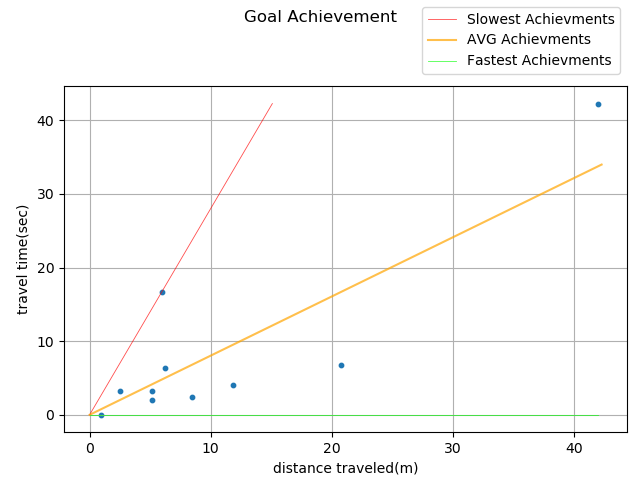

In [14]:
for it in range(2):
    if it==0: plt.figure()
    else: plt.figure(dpi=1200)
    if reached:
        significant_points = [slowest_goal,fastest_goal]
        sig_time,sig_dist,max_time,max_dist = ([],[],0,0)
        for point in significant_points:
            for dist,time in reached.values():
                if time/dist==point:
                    sig_time.append(time)
                    sig_dist.append(dist)
                if time > max_time: max_time = time
                if dist > max_dist: max_dist = dist
        plt.plot([0,sig_dist[0],max_time/slowest_goal],[0,sig_time[0],max_time],c='red',label='Slowest Achievments',alpha=0.7,linewidth=0.6)
        plt.plot([0,max_time],[0,max_time*avg_goal],label='AVG Achievments',c='orange',alpha=0.7)
        plt.plot([0,sig_dist[1],max_dist],[0,sig_time[1],max_dist*fastest_goal],c='lime',label='Fastest Achievments',alpha=0.7,linewidth=0.6)
    plt.scatter([tuplett[0] for tuplett in reached.values()],[tuplett[1] for tuplett in reached.values()],s=10)
    plt.suptitle('Goal Achievement')
    plt.ylabel("travel time(sec)")
    plt.xlabel("distance traveled(m)")
    plt.legend(bbox_to_anchor=(1.0,1.25))
    plt.subplots_adjust(left=0.10,bottom=0.10,top=0.82,right=0.98)
    plt.grid()
    if it==0: plt.show()
    else:     
        plt.savefig(path_lib.join(log_path,"plots","ConSteer",SCENE_NAME.strip(".csv")+"_goal.png"))
        plt.clf()
        plt.close();

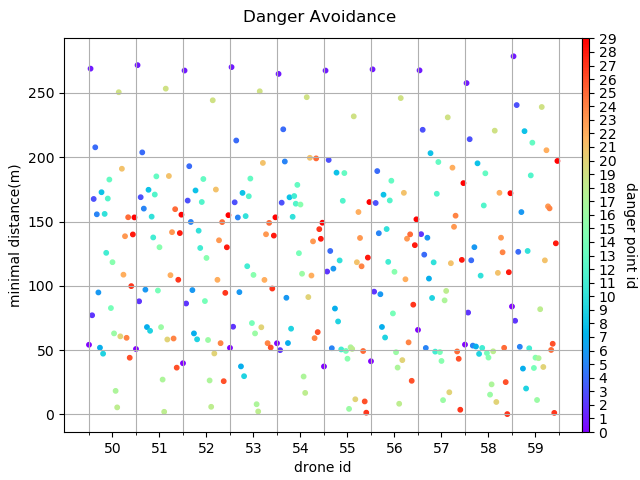

In [15]:
for it in range(2):
    if it==0: plt.figure()
    else: plt.figure(dpi=1200)
    plt.suptitle('Danger Avoidance')
    plt.xticks([*range(int(len(scene["rep"])/2),len(min_dist),len(scene["rep"]))], drone_ids["conSteer"])
    ax = plt.gca()
    colors = np.array([*range(len(scene["rep"]))]*len(drone_ids["conSteer"]))*10
    plot = ax.scatter([*range(len(min_dist))],[tuplett[1] for tuplett in min_dist.values()],c=colors,cmap='rainbow',s=10) 
    ax.set_ylabel("minimal distance(m)")
    ax.set_xlabel("drone id")
    ax.set_xticks([*range(0,len(min_dist),len(scene["rep"])),len(min_dist)], minor=True)
    ax.xaxis.grid(which='minor',alpha=1.0)
    ax.yaxis.grid(alpha=1.0)
    cbar = plt.colorbar(plot, cax=plt.axes([0.91, 0.10, 0.01, 0.82]), cmap='rainbow', ticks=np.array([*range(len(scene["rep"]))])*10)
    cbar.ax.set_yticklabels([*range(len(scene["rep"]))])
    cbar.ax.set_ylabel('danger point id',rotation=270,labelpad=15)
    plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.91)
    if it==0: plt.show()
    else: 
        plt.savefig(path_lib.join(log_path,"plots","ConSteer",SCENE_NAME.strip(".csv")+"_danger.png"))
        plt.clf()
        plt.close();

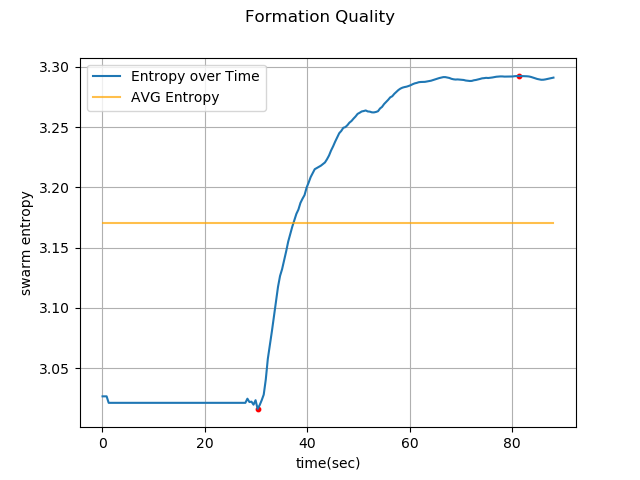

In [16]:
for it in range(2):
    if it==0: plt.figure()
    else: plt.figure(dpi=1200)
    plt.grid()
    plt.plot(timestamps,entropy,label='Entropy over Time')
    plt.plot([timestamps[0],timestamps[-1]],[avg_entropy,avg_entropy],label='AVG Entropy',c='orange',alpha=0.7)
    significant_points = [smallest_entropy,largest_entropy]
    plt.scatter([timestamps[entropy.index(point)] for point in significant_points],significant_points,c='red',s=10)
    plt.suptitle('Formation Quality')
    plt.ylabel("swarm entropy")
    plt.xlabel("time(sec)")
    plt.legend()
    if it==0: plt.show()
    else: 
        plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.98)
        plt.savefig(path_lib.join(log_path,"plots","ConSteer",SCENE_NAME.strip(".csv")+"_entropy.png"))
        plt.clf()
        plt.close();

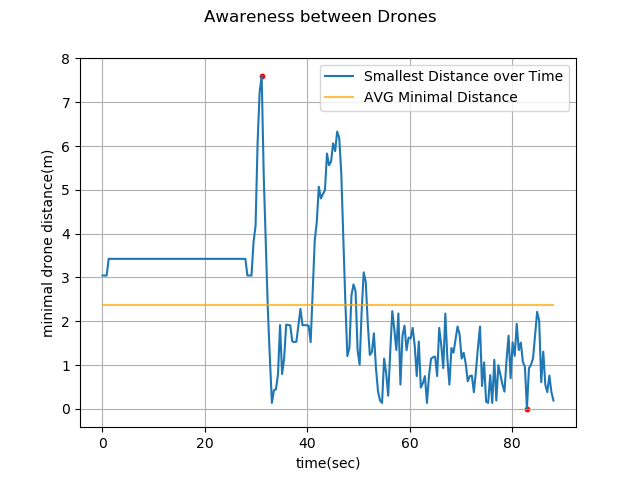

In [17]:
for it in range(2):
    if it==0: plt.figure()
    else: plt.figure(dpi=1200)
    plt.grid()
    plt.plot(timestamps,dr_min_dist,label="Smallest Distance over Time")
    plt.plot([timestamps[0],timestamps[-1]],[avg_ddist,avg_ddist],label='AVG Minimal Distance',c='orange',alpha=0.7)
    significant_points = [smallest_ddist,furthest_ddist]
    plt.scatter([timestamps[dr_min_dist.index(point)] for point in significant_points],significant_points,c='red',s=10)
    plt.suptitle('Awareness between Drones')
    plt.ylabel("minimal drone distance(m)")
    plt.xlabel("time(sec)")
    plt.legend()
    if it==0: plt.show()
    else: 
        plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.98)
        plt.savefig(path_lib.join(log_path,"plots","ConSteer",SCENE_NAME.strip(".csv")+"_drones.png"))
        plt.clf()
        plt.close();

# Evaluation of Attraction-Repulsion Behaviour

In [18]:
drone_protocol = dict()
timestamps = list()

for d_id,file_path in zip(drone_ids["attRep"],attRep_files):
    drone_protocol[d_id] = dict()
    with open(file_path,"r") as file:
        d_timestamps = list()
        lines = file.readlines()
        for line in lines[1:-1]:
            key = float(line.split("]")[0].strip("[").strip())
            pos = [float(coord.strip()) for coord in line.split("pos:")[-1].split("/")[0].split(",")]
            drone_protocol[d_id][key] = pos
            d_timestamps.append(key)
        if d_id == drone_ids["attRep"][0]: timestamps = d_timestamps
        else: timestamps = [timestamp for timestamp in timestamps if timestamp in d_timestamps]

print(drone_protocol.keys())
for key in drone_protocol.keys():
    print("-> protocol from drone "+str(key)+": ")
    print("   first_timestamp:",list(drone_protocol[key].keys())[0])
    print("   first_pos:",drone_protocol[key][list(drone_protocol[key].keys())[0]])
    print("   timestamp_amount:",len(drone_protocol[key].keys()))


dict_keys([30, 31, 32, 33, 34, 35, 36, 37, 38, 39])
-> protocol from drone 30: 
   first_timestamp: 0.066436
   first_pos: [52.13846418, 11.64485099]
   timestamp_amount: 2863
-> protocol from drone 31: 
   first_timestamp: 0.066436
   first_pos: [52.13799631, 11.64416028]
   timestamp_amount: 2863
-> protocol from drone 32: 
   first_timestamp: 0.066436
   first_pos: [52.13783922, 11.64487916]
   timestamp_amount: 2863
-> protocol from drone 33: 
   first_timestamp: 0.066436
   first_pos: [52.13786995, 11.64462132]
   timestamp_amount: 614
-> protocol from drone 34: 
   first_timestamp: 0.066436
   first_pos: [52.13742258, 11.64456497]
   timestamp_amount: 2863
-> protocol from drone 35: 
   first_timestamp: 0.066436
   first_pos: [52.13800656, 11.64478354]
   timestamp_amount: 2863
-> protocol from drone 36: 
   first_timestamp: 0.066436
   first_pos: [52.13789727, 11.64461876]
   timestamp_amount: 2863
-> protocol from drone 37: 
   first_timestamp: 0.066436
   first_pos: [52.137883

In [19]:
scene = dict()

with open(scene_path, "r") as file:
    lines = file.readlines()
    for line in lines[2:]:
        vals = [val.strip() for val in line.split(",")]
        scene[vals[-1]] = scene.get(vals[-1], [])
        scene[vals[-1]].append([round(float(vals[0]),8),round(float(vals[1]),8)])

print(scene.keys())
for key in scene.keys():
    print("-> "+str(key)+"s in scene: ")
    print("   first_"+str(key)+":",scene[key][0])
    print("   "+str(key)+"_amount:",len(scene[key]))

dict_keys(['rep', 'att', 'spawn'])
-> reps in scene: 
   first_rep: [52.13806987, 11.64556749]
   rep_amount: 30
-> atts in scene: 
   first_att: [52.13878079, 11.6445159]
   att_amount: 30
-> spawns in scene: 
   first_spawn: [52.13788439, 11.64478467]
   spawn_amount: 10


Attraction Point Achievement Analysis

In [20]:
reached = {}
last_att_time = 0
last_drone_pos = [drone_protocol[d_id][timestamps[0]] for d_id in drone_protocol.keys()]
for timestamp in timestamps:
    for d_id in drone_protocol.keys():
        for att_id, att in enumerate(scene["att"]):
            if getDistance(*drone_protocol[d_id][timestamp],*att) < 1.5 \
            and not reached.get(str(d_id)+"->"+str(att_id), None):
                reached[str(d_id)+"->"+str(att_id)] = [getDistance(*last_drone_pos[drone_ids["attRep"].index(d_id)],*att),timestamp-last_att_time]
                last_drone_pos = [drone_protocol[d_id][timestamp] for d_id in drone_protocol.keys()]
                last_att_time = timestamp

for key in reached.keys():
    print("Drone",key.split("->")[0],"reached ATT Point",key.split("->")[1],"approximately after",
    str(reached[key][1])+"sec and {:.8f}m of travel.".format(reached[key][0]))

Repulsion Zone Avoidance Analysis

In [21]:
min_dist = {}
for timestamp in timestamps:
    for d_id in drone_protocol.keys():
        for rep_id, rep in enumerate(scene["rep"]):
            dist = getDistance(*drone_protocol[d_id][timestamp],*rep)
            if not min_dist.get(str(d_id)+"<->"+str(rep_id), None) \
            or dist < min_dist[str(d_id)+"<->"+str(rep_id)][1]:
                min_dist[str(d_id)+"<->"+str(rep_id)] = [timestamp, dist]

for key in min_dist.keys():
    print("Smallest distance between Drone",key.split("<->")[0],"and REP Point",key.split("<->")[1],
    "was {0:.8f}m and occured".format(round(min_dist[key][1],8)),
    "{0:.6f}sec after simulation start.".format(min_dist[key][0]))

Smallest distance between Drone 30 and REP Point 0 was 65.63016604m and occured 29.579653sec after simulation start.
Smallest distance between Drone 30 and REP Point 1 was 237.54056075m and occured 38.396099sec after simulation start.
Smallest distance between Drone 30 and REP Point 2 was 140.15877780m and occured 0.066436sec after simulation start.
Smallest distance between Drone 30 and REP Point 3 was 209.47967744m and occured 38.396099sec after simulation start.
Smallest distance between Drone 30 and REP Point 4 was 105.17807069m and occured 38.396099sec after simulation start.
Smallest distance between Drone 30 and REP Point 5 was 75.42368945m and occured 38.333572sec after simulation start.
Smallest distance between Drone 30 and REP Point 6 was 130.19710722m and occured 37.895878sec after simulation start.
Smallest distance between Drone 30 and REP Point 7 was 105.61286290m and occured 0.066436sec after simulation start.
Smallest distance between Drone 30 and REP Point 8 was 184.7

Swarming Analysis

In [22]:
entropy = list()
for timestamp in timestamps:
    drone_pos = np.array([drone_protocol[d_id][timestamp] for d_id in drone_protocol.keys()])
    centeroid = np.average(drone_pos,axis=0)
    dist = np.linalg.norm(drone_pos - centeroid, axis=1)
    probs = dist/np.sum(dist)
    entropy.append(-np.sum(probs*np.log2(probs)))
print("Average Entropy: {:.4f} - std: {:.4f}".format(np.average(entropy),np.std(entropy)))


Average Entropy: 3.0204 - std: 0.0073


In [23]:
dr_min_dist = list()
drone_pairs = list()
for timestamp in timestamps:
    drone_pos = np.array([drone_protocol[d_id][timestamp] for d_id in drone_protocol.keys()])
    min_drone_dist = dict()
    for i,d_pos in enumerate(drone_pos):
        dists = dict()
        for j,o_pos in enumerate(drone_pos[i+1:]):
            if d_pos[0]-o_pos[0] == 0 and d_pos[1]-o_pos[1] == 0: dists[0] = str(i)+"<->"+str(j+i+1)
            else: dists[abs(getDistance(*d_pos,*o_pos))] = str(i)+"<->"+str(j+i+1)
        if dists: min_drone_dist[np.min(list(dists.keys()))] = dists[np.min(list(dists.keys()))]
    dr_min_dist.append(np.min(list(min_drone_dist.keys())))
    drone_pairs.append(min_drone_dist[dr_min_dist[-1]])

for key,dist,time in zip(drone_pairs[::75],dr_min_dist[::75],timestamps[::75]):
    print("Smallest distance between Drone",str(drone_ids["attRep"][int(key.split("<->")[0])]),"and Drone",
    str(drone_ids["attRep"][int(key.split("<->")[1])]),"was {0:.8f}m and occured".format(round(dist,8)),
    "{0:.6f}sec after simulation start.".format(time))

Smallest distance between Drone 33 and Drone 36 was 3.04385721m and occured 0.066436sec after simulation start.
Smallest distance between Drone 33 and Drone 36 was 3.42425711m and occured 4.756036sec after simulation start.
Smallest distance between Drone 33 and Drone 36 was 3.42425711m and occured 9.445636sec after simulation start.
Smallest distance between Drone 33 and Drone 36 was 3.42425711m and occured 14.135236sec after simulation start.
Smallest distance between Drone 33 and Drone 36 was 3.42425711m and occured 18.824837sec after simulation start.
Smallest distance between Drone 33 and Drone 36 was 3.42425711m and occured 23.514437sec after simulation start.
Smallest distance between Drone 33 and Drone 36 was 3.42425711m and occured 28.204037sec after simulation start.
Smallest distance between Drone 33 and Drone 36 was 3.42294085m and occured 32.893635sec after simulation start.
Smallest distance between Drone 33 and Drone 36 was 3.42030680m and occured 37.583237sec after simu

Behaviour Evaluation

In [24]:
# Attraction Stats
fastest_att,slowest_att,avg_att,std_att,percentiles_att = (-1,-1,-1,-1,[-1,-1,-1])
if reached:
    fastest_att = min([tuplett[1]/tuplett[0] for tuplett in reached.values()])
    slowest_att = max([tuplett[1]/tuplett[0] for tuplett in reached.values()])
    avg_att = np.average([tuplett[1]/tuplett[0] for tuplett in reached.values()])
    std_att = np.std([tuplett[1]/tuplett[0] for tuplett in reached.values()])
    percentiles_att = np.percentile([tuplett[1]/tuplett[0] for tuplett in reached.values()],[25,50,75])

    print("Attraction Stats:\n-----------")
    print("Shortest travel time to attraction point: {:>5.2f} sec/m".format(round(fastest_att,2)))
    print("Average travel time to attraction point:  {:>5.2f} sec/m".format(round(avg_att,2)))
    print("Longest travel time to attraction point:  {:>5.2f} sec/m".format(round(slowest_att,2)))
    print("Standard Deviation in travel times:       {:>5.2f} sec/m".format(round(std_att,2)))
    print("First percentile(Q1) in travel times:     {:>5.2f} sec/m".format(round(percentiles_att[0],2)))
    print("Median(2nd percentile) in travel times:   {:>5.2f} sec/m".format(round(percentiles_att[1],2)))
    print("Third percentile(Q3) in travel times:     {:>5.2f} sec/m".format(round(percentiles_att[2],2)))
else:
    print("No Attraction Points Reached!")


No Attraction Points Reached!


In [25]:
# Repulsion Stats
smallest_dist = min([tuplett[1] for tuplett in min_dist.values()])
furthest_dist = max([tuplett[1] for tuplett in min_dist.values()])
avg_dist = np.average([tuplett[1] for tuplett in min_dist.values()])
std_dist = np.std([tuplett[1] for tuplett in min_dist.values()])
percentiles_dist = np.percentile([tuplett[1] for tuplett in min_dist.values()],[25,50,75])

print("\nRepulsion Stats:\n-------------")
print("Smallest minimal distance to repulsion center: {:>6.2f} m".format(round(smallest_dist,2)))
print("Average minimal distance to repulsion center:  {:>6.2f} m".format(round(avg_dist,2)))
print("Furthest minimal distance to repulsion center: {:>6.2f} m".format(round(furthest_dist,2)))
print("Standard Deviation in minimal distances:       {:>6.2f} m".format(round(std_dist,2)))
print("First percentile(Q1) in minimal distances:     {:>6.2f} m".format(round(percentiles_dist[0],2)))
print("Median(2nd percentile) in minimal distances:   {:>6.2f} m".format(round(percentiles_dist[1],2)))
print("Third percentile(Q3) in minimal distances:     {:>6.2f} m".format(round(percentiles_dist[2],2)))


Repulsion Stats:
-------------
Smallest minimal distance to repulsion center:   1.31 m
Average minimal distance to repulsion center:  118.99 m
Furthest minimal distance to repulsion center: 292.97 m
Standard Deviation in minimal distances:        64.37 m
First percentile(Q1) in minimal distances:      67.48 m
Median(2nd percentile) in minimal distances:   118.79 m
Third percentile(Q3) in minimal distances:     162.66 m


In [26]:
# Swarm Stats
smallest_entropy = min(entropy)
largest_entropy = max(entropy)
avg_entropy = np.average(entropy)
std_entropy = np.std(entropy)
percentiles_entropy = np.percentile(entropy,[25,50,75])

smallest_ddist = min(dr_min_dist)
furthest_ddist = max(dr_min_dist)
avg_ddist = np.average(dr_min_dist)
std_ddist = np.std(dr_min_dist)
percentiles_ddist = np.percentile(dr_min_dist,[25,50,75])

print("\nSwarm Stats:\n-------------")
print("Smallest entropy of swarm formation:         {:>6.4f}".format(round(smallest_entropy,4)))
print("Average entropy of swarm formation:          {:>6.4f}".format(round(avg_entropy,4)))
print("Largest entropy of swarm formation:          {:>6.4f}".format(round(largest_entropy,4)))
print("Standard Deviation in formation entropy:     {:>6.4f}".format(round(std_entropy,4)))
print("First percentile(Q1) in formation entropy:   {:>6.4f}".format(round(percentiles_entropy[0],4)))
print("Median(2nd percentile) in formation entropy: {:>6.4f}".format(round(percentiles_entropy[1],4)))
print("Third percentile(Q3) in formation entropy:   {:>6.4f}".format(round(percentiles_entropy[2],4)))
print("-----------------------------------------------------")
print("Smallest minimal distance to other drones:   {:>6.2f} m".format(round(smallest_ddist,2)))
print("Average minimal distance to other drones:    {:>6.2f} m".format(round(avg_ddist,2)))
print("Furthest minimal distance to other drones:   {:>6.2f} m".format(round(furthest_ddist,2)))
print("Standard Deviation in minimal distances:     {:>6.2f} m".format(round(std_ddist,2)))
print("First percentile(Q1) in minimal distances:   {:>6.2f} m".format(round(percentiles_ddist[0],2)))
print("Median(2nd percentile) in minimal distances: {:>6.2f} m".format(round(percentiles_ddist[1],2)))
print("Third percentile(Q3) in minimal distances:   {:>6.2f} m".format(round(percentiles_ddist[2],2)))


Swarm Stats:
-------------
Smallest entropy of swarm formation:         2.9570
Average entropy of swarm formation:          3.0204
Largest entropy of swarm formation:          3.0265
Standard Deviation in formation entropy:     0.0073
First percentile(Q1) in formation entropy:   3.0211
Median(2nd percentile) in formation entropy: 3.0211
Third percentile(Q3) in formation entropy:   3.0211
-----------------------------------------------------
Smallest minimal distance to other drones:     3.04 m
Average minimal distance to other drones:      3.37 m
Furthest minimal distance to other drones:     3.81 m
Standard Deviation in minimal distances:       0.14 m
First percentile(Q1) in minimal distances:     3.42 m
Median(2nd percentile) in minimal distances:   3.42 m
Third percentile(Q3) in minimal distances:     3.42 m


In [27]:
# Save Stats to file
result_file_path = path_lib.join(log_path, "attRep_"+SCENE_NAME.strip(".csv")+"_res.csv")
with open(result_file_path, "w") as results:
    results.write("{:.12f},{:.12f},{:.12f},{:.12f},{:.12f},{:.12f}\n".format(
        round(slowest_att,12),round(avg_att,12),round(fastest_att,12),
        round(std_att,12),round(percentiles_att[0],12),
        round(percentiles_att[1],12),round(percentiles_att[2],12)))
    results.write("{:.12f},{:.12f},{:.12f},{:.12f},{:.12f},{:.12f}\n".format(
        round(smallest_dist,12),round(avg_dist,12),round(furthest_dist,12),
        round(std_dist,12),round(percentiles_dist[0],12),
        round(percentiles_dist[1],12),round(percentiles_dist[2],12)))
    results.write("{:.12f},{:.12f},{:.12f},{:.12f},{:.12f},{:.12f}\n".format(
        round(smallest_entropy,12),round(avg_entropy,12),round(largest_entropy,12),
        round(std_entropy,12),round(percentiles_entropy[0],12),
        round(percentiles_entropy[1],12),round(percentiles_entropy[2],12)))
    results.write("{:.12f},{:.12f},{:.12f},{:.12f},{:.12f},{:.12f}\n".format(
        round(smallest_ddist,12),round(avg_ddist,12),round(furthest_ddist,12),
        round(std_ddist,12),round(percentiles_ddist[0],12),
        round(percentiles_ddist[1],12),round(percentiles_ddist[2],12)))
print("Saved Results to",result_file_path)

Saved Results to /home/finkensim/paparazzi/logs/attRep_random_6446788_res.csv


No handles with labels found to put in legend.


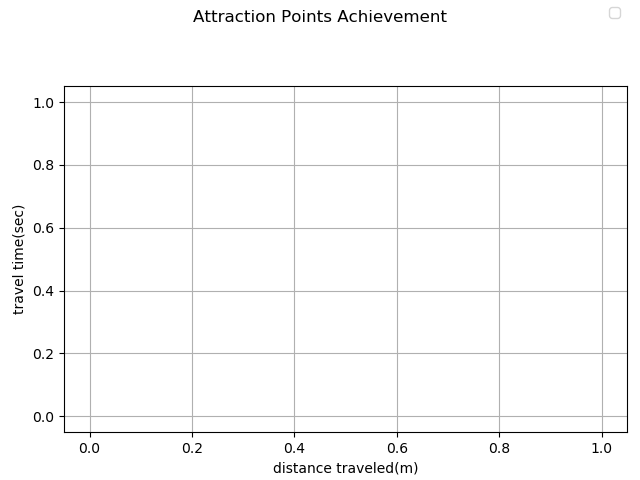

No handles with labels found to put in legend.


In [28]:
for it in range(2):
    if it==0: plt.figure()
    else: plt.figure(dpi=1200)
    if reached:
        significant_points = [slowest_att,fastest_att]
        sig_time,sig_dist,max_time,max_dist = ([],[],0,0)
        for point in significant_points:
            for dist,time in reached.values():
                if time/dist==point:
                    sig_time.append(time)
                    sig_dist.append(dist)
                if time > max_time: max_time = time
                if dist > max_dist: max_dist = dist
        plt.plot([0,sig_dist[0],max_time/slowest_att],[0,sig_time[0],max_time],c='red',label='Slowest Achievments',alpha=0.7,linewidth=0.6)
        plt.plot([0,max_time],[0,max_time*avg_att],label='AVG Achievments',c='orange',alpha=0.7)
        plt.plot([0,sig_dist[1],max_dist],[0,sig_time[1],max_dist*fastest_att],c='lime',label='Fastest Achievments',alpha=0.7,linewidth=0.6)
    plt.scatter([tuplett[0] for tuplett in reached.values()],[tuplett[1] for tuplett in reached.values()],s=10)
    plt.suptitle('Attraction Points Achievement')
    plt.ylabel("travel time(sec)")
    plt.xlabel("distance traveled(m)")
    plt.legend(bbox_to_anchor=(1.0,1.25))
    plt.subplots_adjust(left=0.10,bottom=0.10,top=0.82,right=0.98)
    plt.grid()
    if it==0: plt.show()
    else:     
        plt.savefig(path_lib.join(log_path,"plots","AttRep",SCENE_NAME.strip(".csv")+"_att.png"))
        plt.clf()
        plt.close();

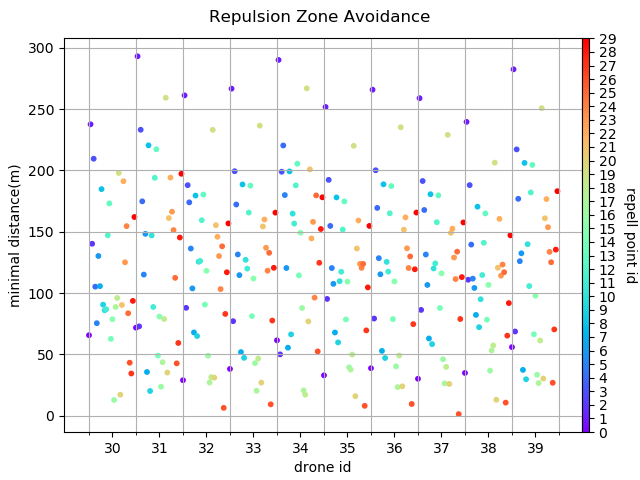

In [29]:
for it in range(2):
    if it==0: plt.figure()
    else: plt.figure(dpi=1200)
    plt.suptitle('Repulsion Zone Avoidance')
    plt.xticks([*range(int(len(scene["rep"])/2),len(min_dist),len(scene["rep"]))], drone_ids["attRep"])
    ax = plt.gca()
    colors = np.array([*range(len(scene["rep"]))]*len(drone_ids["attRep"]))*10
    plot = ax.scatter([*range(len(min_dist))],[tuplett[1] for tuplett in min_dist.values()],c=colors,cmap='rainbow',s=10) 
    ax.set_ylabel("minimal distance(m)")
    ax.set_xlabel("drone id")
    ax.set_xticks([*range(0,len(min_dist),len(scene["rep"])),len(min_dist)], minor=True)
    ax.xaxis.grid(which='minor',alpha=1.0)
    ax.yaxis.grid(alpha=1.0)
    cbar = plt.colorbar(plot, cax=plt.axes([0.91, 0.10, 0.01, 0.82]), cmap='rainbow', ticks=np.array([*range(len(scene["rep"]))])*10)
    cbar.ax.set_yticklabels([*range(len(scene["rep"]))])
    cbar.ax.set_ylabel('repell point id',rotation=270,labelpad=15)
    plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.91)
    if it==0: plt.show()
    else: 
        plt.savefig(path_lib.join(log_path,"plots","AttRep",SCENE_NAME.strip(".csv")+"_rep.png"))
        plt.clf()
        plt.close();

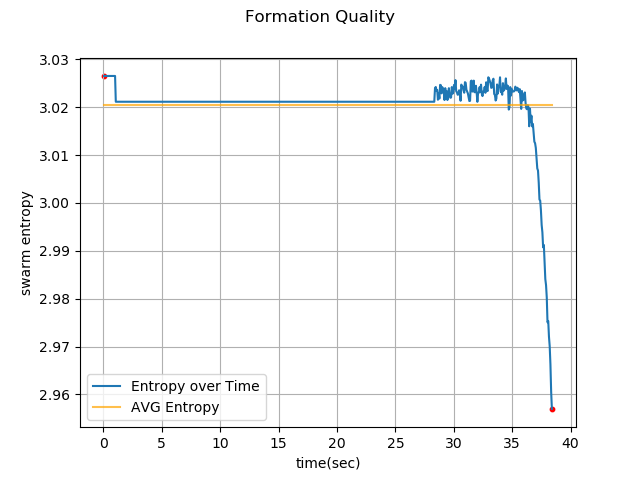

In [30]:
for it in range(2):
    if it==0: plt.figure()
    else: plt.figure(dpi=1200)
    plt.grid()
    plt.plot(timestamps,entropy,label='Entropy over Time')
    plt.plot([timestamps[0],timestamps[-1]],[avg_entropy,avg_entropy],label='AVG Entropy',c='orange',alpha=0.7)
    significant_points = [smallest_entropy,largest_entropy]
    plt.scatter([timestamps[entropy.index(point)] for point in significant_points],significant_points,c='red',s=10)
    plt.suptitle('Formation Quality')
    plt.ylabel("swarm entropy")
    plt.xlabel("time(sec)")
    plt.legend()
    if it==0: plt.show()
    else: 
        plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.98)
        plt.savefig(path_lib.join(log_path,"plots","AttRep",SCENE_NAME.strip(".csv")+"_entropy.png"))
        plt.clf()
        plt.close();

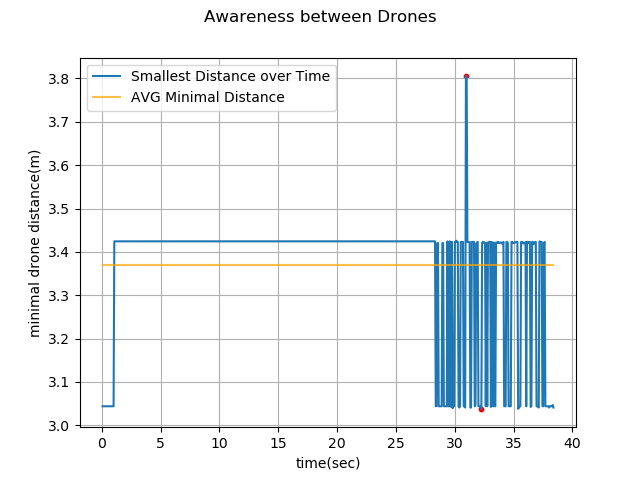

In [31]:
for it in range(2):
    if it==0: plt.figure()
    else: plt.figure(dpi=1200)
    plt.grid()
    plt.plot(timestamps,dr_min_dist,label="Smallest Distance over Time")
    plt.plot([timestamps[0],timestamps[-1]],[avg_ddist,avg_ddist],label='AVG Minimal Distance',c='orange',alpha=0.7)
    significant_points = [smallest_ddist,furthest_ddist]
    plt.scatter([timestamps[dr_min_dist.index(point)] for point in significant_points],significant_points,c='red',s=10)
    plt.suptitle('Awareness between Drones')
    plt.ylabel("minimal drone distance(m)")
    plt.xlabel("time(sec)")
    plt.legend()
    if it==0: plt.show()
    else: 
        plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.98)
        plt.savefig(path_lib.join(log_path,"plots","AttRep",SCENE_NAME.strip(".csv")+"_drones.png"))
        plt.clf()
        plt.close();